# Modeling - Notebook 3

- [Imports and Reading in Data](#Imports-and-Reading-in-Data)
- [Baseline Score](#Baseline-Score)
- [Vectorizing and Setting up for Modeling](#Vectorizing-and-Setting-up-for-Modeling)
-- [Pipelines](#Pipelines)
-- [Models and Scoring](#Models-and-Scores)
- [Visualizations](#Visualizations)
-- [Confusion Matrix](#Confusion-Matrix)
-- [Top Features](#Top-Features)
- [Conclusions](#Conclusions)

## Imports and Reading in Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data
df = pd.read_csv('../data/clean_df.csv')

# checking for null values
df.isnull().sum()

full_text         0
beyondbump        0
word_count        0
tokenized_text    0
stemmed_text      0
question_mark     0
something_old     0
dtype: int64

In [3]:
df.head()

,full_text,beyondbump,word_count,tokenized_text,stemmed_text,question_mark,something_old
0,"prenatals without iron!? for the love of god, ...",0,80,prenatals without iron ! ? for the love of god...,"prenat without iron ! ? for the love of god , ...",1,0
1,told our parents my bf and i told our parents ...,0,385,told our parents my bf and i told our parents ...,told our parent my bf and i told our parent ab...,0,0
2,doctor asked me to gain weight - should i get ...,0,171,doctor asked me to gain weight - should i get ...,doctor ask me to gain weight - should i get a ...,1,0
3,"take the stool softeners, &amp; for the love o...",0,197,"take the stool softeners , & amp ; for the lov...","take the stool soften , & amp ; for the love o...",0,0
4,ummm blotches on skin??? i can't be the only o...,0,29,ummm blotches on skin ? ? ? i ca n't be the on...,ummm blotch on skin ? ? ? i ca n't be the onli...,1,0


In [4]:
df.shape

(3649, 7)

## Baseline Score

In [5]:
# what is our baseline? 
# we created the data set by choosing 2000 of each
# and a few have been deleted
1 - df['beyondbump'].mean()

0.5245272677445876

## Vectorizing and Setting up for Modeling

Through EDA I tokenized and lemmatized my text. After running models on the 'full_text', the tokenized text, and the tokenized and lemmatized text, it turns out lemmatizing did not improve my model. After, I decided to see if stemming (post tokenizing) improved my model. It did (albeit slightly), so I kept the tokenized and stemmed text for my model.  

The stop words that we excluded were the variants of the title of each subreddit. The model was built this way so that we might be able to generalize to data scraped from other sources beyond Reddit. 

In [33]:
# setting up stop words for vectorizing
my_stop_words = text.ENGLISH_STOP_WORDS.union(['pregnant', 'pregnancy', 'preggo', 'expecting',
                                               'baby', 'bump', 'just'])
# vectorizing
tvec = TfidfVectorizer(stop_words = my_stop_words, 
                       strip_accents = 'ascii', 
                       max_features = 200, 
                       norm = 'l2')

tvec.fit(df['stemmed_text'])


TfidfVectorizer(max_features=200,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii')

In [34]:
# setting up X and y
X_tvec = pd.DataFrame(tvec.transform(df['stemmed_text']).todense(), 
                          columns = tvec.get_feature_names())

# include word_count and question_mark as features in my model
X_tvec['word_count'] = df['word_count']
X_tvec['question_mark'] = df['question_mark']

y = df['beyondbump']

In [35]:
X_tvec.isnull().sum().sum()

0

### Pipelines

In [36]:
# need to scale data for knn and logisticregression
# use pipeline since we don't need standard scaled data for random forest
knn_pipe = Pipeline([
    ('ss', StandardScaler()), 
    ('knn', KNeighborsClassifier())
])

lr_pipe = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])


### Models and Scores

In [1]:
# instantiating my models
# found these numbers for RF through gridsearch

rf = RandomForestClassifier(n_estimators=100, 
                            min_samples_leaf=2, 
                            max_depth=8)
knn = KNeighborsClassifier()
lr = LogisticRegression()

# creating variables for cross_validate scores
rf_scores = cross_validate(rf, X_tvec, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73),
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

knn_scores = cross_validate(knn_pipe, X_tvec, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73), 
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

lr_scores = cross_validate(lr_pipe, X_tvec, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73),
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)

# saving scores into separate dataframes
rf_results = pd.DataFrame(rf_scores)
knn_results = pd.DataFrame(knn_scores)
lr_results = pd.DataFrame(lr_scores)

# used cross validation lecture 2 notes to figure out cross_validate

NameError: name 'RandomForestClassifier' is not defined

Random Forest: an ensemble of decision trees, adding additional randomness while growing trees. Unlike the Decision Tree alone, it searches for the best feature among a subset of features.

I tried a Random Forest first since it is very easy to measure the relative importance of each feature on the prediction. 

In [38]:
rf_results

,fit_time,score_time,estimator,test_score,train_score
0,0.548908,0.020505,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.783562,0.853374
1,0.583012,0.021623,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.798630,0.848236
2,0.528928,0.023676,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.826027,0.845838
3,0.549399,0.017282,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.793151,0.842412
4,0.548643,0.015393,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.812071,0.848630


In [39]:
# comparing train and test cross validate scores
# model is overfit (as happens a lot with trees)
round(rf_results['test_score'].mean(), 2), round(rf_results['train_score'].mean(), 2)

(0.8, 0.85)

In [40]:
# including confidence interval for random forest (from test scores)
print(f'{round(rf_results.test_score.mean(), 2)} ± {round(2 * rf_results.test_score.std(), 2)}')

0.8 ± 0.03


KNearestNeighbors: Commonly used for its ease of interpretation and low calculation time. 
In our case, it drastically overfit the model. This would not be a good model to use because of the high variance of the model. 

In [41]:
knn_results
# no need to look compare train and test since the model is so drastically overfit
# we can easily see it from the dataframe

,fit_time,score_time,estimator,test_score,train_score
0,0.026579,0.088045,"(StandardScaler(), KNeighborsClassifier())",0.691781,0.823570
1,0.043513,0.159789,"(StandardScaler(), KNeighborsClassifier())",0.738356,0.807811
2,0.026337,0.087717,"(StandardScaler(), KNeighborsClassifier())",0.713699,0.813635
3,0.043006,0.165164,"(StandardScaler(), KNeighborsClassifier())",0.709589,0.810552
4,0.038937,0.171629,"(StandardScaler(), KNeighborsClassifier())",0.680384,0.805822


Logistic Regression models the probability of the positive class. 

The beta coefficients can be more difficult to interpret than the coefficients of Random Forest.

In [42]:
lr_results

,fit_time,score_time,estimator,test_score,train_score
0,0.105713,0.008470,"(StandardScaler(), LogisticRegression())",0.801370,0.845495
1,0.101171,0.006363,"(StandardScaler(), LogisticRegression())",0.794521,0.842412
2,0.095817,0.007499,"(StandardScaler(), LogisticRegression())",0.815068,0.836588
3,0.096756,0.006486,"(StandardScaler(), LogisticRegression())",0.779452,0.848578
4,0.044672,0.004197,"(StandardScaler(), LogisticRegression())",0.791495,0.841781


In [43]:
# comparing train and test cross validate scores
round(lr_results['test_score'].mean(), 2), round(lr_results['train_score'].mean(), 2)
# this model is exactly as overfit as Random Forest, though accuracy in the test data 
# is 1% lower

(0.8, 0.84)

In [44]:
# including confidence interval
print(f'{round(lr_results.test_score.mean(), 2)} ± {round(2 * lr_results.test_score.std(), 2)}')

0.8 ± 0.03


In [283]:
# ensembling 

vote = VotingClassifier([
    ('forest', RandomForestClassifier(n_estimators=100, 
                            min_samples_leaf=2, 
                            max_depth=8)),
    ('grad_boost', GradientBoostingClassifier()),
    ('knn_pipe', knn_pipe), 
    ('lr_pipe', lr_pipe)
])

params = {
    'grad_boost__n_estimators': [75, 100],
    'knn_pipe__knn__n_neighbors': [4, 5, 6],
    'weights': [[0.25, 0.25, 0.25, 0.25], [0.2, 0.3, 0.2, 0.3]]
}

gs = GridSearchCV(vote, param_grid=params)
gs.fit(X_tvec, y)
print(gs.best_score_)
gs.best_params_


0.810352331022042


{'grad_boost__n_estimators': 100,
 'knn_pipe__knn__n_neighbors': 5,
 'weights': [0.2, 0.3, 0.2, 0.3]}

In [284]:
# Voting Classifier with best params - doing cross validate
knn_pipe = Pipeline([
    ('ss', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

lr_pipe = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])


vote = VotingClassifier([
    ('forest', RandomForestClassifier(n_estimators=100, 
                            min_samples_leaf=2, 
                            max_depth=8)),
    ('grad_boost', GradientBoostingClassifier(n_estimators=100)),
    ('knn_pipe', knn_pipe), 
    ('lr_pipe', lr_pipe), 
])

# cross_val for voting classifier
vote_scores = cross_validate(vote, X_tvec, y, cv = KFold(n_splits=5, 
                                                      shuffle=True, 
                                                      random_state=73),
                                                      n_jobs=-1,
                                                      return_train_score=True, 
                                                      return_estimator=True)


In [285]:
vote_results = pd.DataFrame(vote_scores)

Voting Classifier is a way to ensemble different models. That said, it is a black box method, so the results would not be easily interpretable. Also, the model has more variance than both Random Forest and Logistic Regression.

In [286]:
vote_results

,fit_time,score_time,estimator,test_score,train_score
0,2.995077,0.106910,"VotingClassifier(estimators=[('forest',\n ...",0.795890,0.866393
1,2.966659,0.131131,"VotingClassifier(estimators=[('forest',\n ...",0.797260,0.867078
2,3.006069,0.134365,"VotingClassifier(estimators=[('forest',\n ...",0.823288,0.862282
3,2.989351,0.158571,"VotingClassifier(estimators=[('forest',\n ...",0.808219,0.868106
4,3.027783,0.140302,"VotingClassifier(estimators=[('forest',\n ...",0.803841,0.865068


In [20]:
# comparing train and test cross validate scores
round(vote_results['test_score'].mean(), 2), round(vote_results['train_score'].mean(), 2)
# more overfit than the Random Forest and Logistic Regression models

NameError: name 'vote_results' is not defined

In [288]:
print(f'{round(vote_results.test_score.mean(), 2)} ± {round(2 * vote_results.test_score.std(), 2)}')

0.81 ± 0.02


# Visualizations

## Confusion Matrix

Taking one of the 5 train/test sets from our Random Forest Model and looking at confusion matrix to see if I can improve the model. 

In [22]:
rf_preds = rf_scores.get('estimator')[1].predict(X_tvec)

In [23]:
metrics.confusion_matrix(y, rf_preds)

array([[1804,  110],
       [ 482, 1253]])

In [24]:
confusion_matrix_df = pd.DataFrame(metrics.confusion_matrix(y, rf_preds))
confusion_matrix_df.rename(columns = {0:'Beyondthebump', 1: 'Pregnant'}, inplace = True)
confusion_matrix_df.rename(index = {0:'Beyondthebump', 1: 'Pregnant'}, inplace = True)
confusion_matrix_df

,Beyondthebump,Pregnant
Beyondthebump,1804,110
Pregnant,482,1253


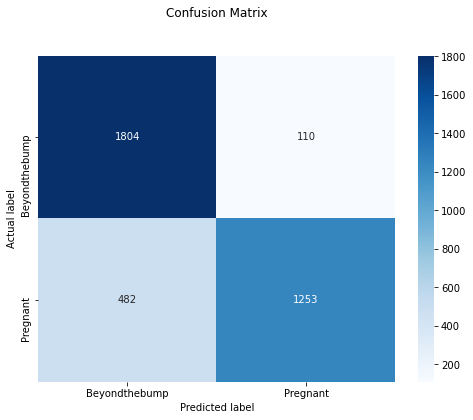

In [25]:

plt.figure(figsize=(8, 6))

# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix_df), annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

# Vivek helped me with this code - I edited

Figure above: confusion matrix - helping to dig into the false positive and false negatives. 

In [29]:
index_list = X_tvec[(rf_preds == 1) & (y != rf_preds)].index
# digging into the false positives (as a way to improve our model)
# posts that were predicted as 'r/beyondthebump' but were really 'r/pregnant'

In [30]:
rows = df.iloc[index_list, :]

In [32]:
rows.full_text

25      does age make a difference in men? hello ladie...
41      virtigo i'm 6 months today and yesterday i sta...
53      when did you start wearing maternity clothes? ...
55      day 1 home and feeding troubles it’s 5:30am an...
66      scared me and my bf use condoms all the times ...
                              ...                        
1799    my son thinks his grandma is his mom. my son i...
1839    was watching unexpected with my partner last n...
1871    diaper bag due nov 6 with baby girl! i have. 2...
1885    pre-natals hi!! i have heard many times from s...
1888    i'm a ftm and we get to find out the sexy of o...
Name: full_text, Length: 110, dtype: object

If this were a longer project, I would begin to analyze these posts and also the false negatives and see what commonalities exist between them to fine tune my classification model. 

## Top Features

In [294]:
# getting features and importances
features = list(X_tvec.columns)
importances = list(rf_scores.get('estimator')[1].feature_importances_)

# zipping them together
features_w_importances = list(zip(importances, features))

# create a dataframe and get top 15 features
top_15_features = pd.DataFrame(sorted(features_w_importances, reverse=True))[:15]

# renaming columns
top_15_features.rename(columns={0:'relative_importance' , 1:'feature'}, inplace=True)

# Andrea helped me with this code

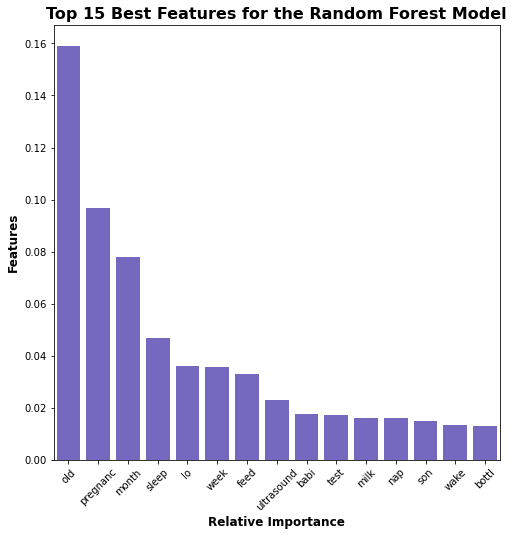

In [295]:
# graph top 15 features
plt.figure(figsize = (8, 8))
sns.barplot(x = top_15_features['feature'], y = top_15_features['relative_importance'], color = 'slateblue')
plt.xlabel('Relative Importance', fontsize = 12, fontweight = 'bold')
plt.ylabel('Features', fontsize = 12, fontweight = 'bold')
plt.xticks(rotation = 45)
plt.title('Top 15 Best Features for the Random Forest Model', fontsize = 16, fontweight = 'bold');

Bar graph above: the top words in relation to our model are shown.

The default method to compute variable importance is the mean decrease in impurity (or gini importance) mechanism: At each split in each tree, the improvement in the split-criterion is the importance measure attributed to the splitting variable, and is accumulated over all the trees in the forest separately for each variable. Note that this measure is quite like the \(R^2\) in regression on the training set. ([Source](#https://blog.hwr-berlin.de/codeandstats/variable-importance-in-random-forests/))

The measure shown above is based on the decrease of Gini impurity when a variable is chosen to split a node. ([Source](#https://www.displayr.com/how-is-variable-importance-calculated-for-a-random-forest/))

In [299]:
# other metrics besides accuracy (which is my original metric from above)
print('Sensitivity:', round(metrics.recall_score(y, rf_preds), 2))
print('Precision:', round(metrics.precision_score(y, rf_preds), 2))

Sensitivity: 0.73
Precision: 0.92


**Sensitivity:** We were around 73% accurate when predicting those in the BeyondtheBump subreddit.

**Precision:** Of all the posts we predicted to be in the BeyondtheBump subreddit, we were correct 92% of the time. 


## Conclusions

After evaluating all the models, the one that I chose for our purposes was the Random Forest model. Through cross validation, I found that we are 95% certain that our model will be 78% - 82% accurate at predicting between the pregnancy subreddit and the beyondthebump subreddit. Though the mean accuracy of the chosen model is one percent below that of the Voting Classifier model, the Random Forest is easier to interpret and also takes less time to run. Random Forest also had lower variance than the Voting Classifer model. 

Given that the desire is to be able to generalize our model across other blogs, posting sites, and social media in order to create marketing campaigns we should be aware of the limitations of this model. The posts that were scraped from Reddit were relatively text heavy (mean around 140 words per post). If we were interested in pulling data from a site that limits post length, the model may not generalize well. 

Moving forward, I propose a continuing project on identifying the types of products that parents post about. Furthermore, we can begin to identify at what age range parents begin to wonder about specific products. Using this information, the marketing team would be able to more successfully target their campaigns for when parents need specific items for their children. 
